<a href="https://colab.research.google.com/github/isdeniz/results-2406/blob/main/model_msc_dataset_msc_preprocessing_msc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install transformers==4.40.2

In [2]:
pip install simpletransformers==0.64.3

In [3]:
import transformers
>>> transformers.__version__

'4.40.2'

In [4]:
import pandas as pd
from functools import partial
import sklearn
import torch
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import logging
import datetime
from sklearn.metrics import confusion_matrix # additional line
import seaborn as sns # additional line
import matplotlib.pyplot as plt # additional line
import torch.multiprocessing # additional line
import os # additional line
os.environ["TOKENIZERS_PARALLELISM"] = "false" # additional line
torch.multiprocessing.set_start_method('spawn', force = True) # additional line
pd.set_option('display.max_colwidth', None)
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)
torch.multiprocessing.set_sharing_strategy('file_system')
cuda_available = torch.cuda.is_available()
print("Is cuda available?", cuda_available)

Is cuda available? True


load and prepare data

In [5]:
train = pd.read_csv('data/train_bug_ench_question_msc_preprocessing.csv')
test = pd.read_csv('data/test_bug_ench_question_msc_preprocessing.csv')
print('Number of issues: ', train.shape, test.shape)

Number of issues:  (94830, 2) (10537, 2)


In [6]:
train.head()

,text,labels
0,2020-06-01T16:01:49Z NONE Anuken/Mindustry issue with drillspeed for laserdrills B platform windows 7 build steam build 104.10 issue a water boosted laserdrill on sand displays 4.94 s but it can't supply 8 oil extractors wich only need 4.8 sand s in total. there is no overflowing sand and the oil lake on the last extractor is smaller compared to the others. for smooth designs it would be nice to get the actuall 4.94 s out of that drill image https user images.githubusercontent.com 66265700 83427216 ac0add00 a430 11ea 9ea5 026092d03b3e.png place an x no spaces between the brackets to confirm that you have read the line below. x i have searched the closed and open issues to make sure that this problem has not already been reported.,0
1,2020-06-03T11:25:20Z CONTRIBUTOR Anuken/Mindustry anti virus program was blocking game B platform windows 10 build 104.10 issue see screenshot image https user images.githubusercontent.com 44261958 83630982 b5827980 a5d7 11ea 8776 37f92c35799a.png download from itch.io steps to reproduce run mindustry.exe link to function used if applicable vanilla crash report if applicable nothing place an x no spaces between the brackets to confirm that you have read the line below. x i have searched the closed and open issues to make sure that this problem has not already been reported.,0
2,2020-06-03T14:27:30Z CONTRIBUTOR Anuken/Mindustry game crashes with a nonexistent item name in the itemdrop key in an ore. B platform android ios mac windows linux linux build the build number under the title in the main menu. required. 104.10 issue explain your issue in detail. my bug report isn't really a bug but it causes the game to crash every time you open it until you delete it out of your mod folder. the bug is that if you have an ore which has the code type oreblock itemdrop put a nonexistent item name here steps to reproduce how you happened across the issue and what you were doing at the time. create a basic mod with only a mod.json and content folder then create a blocks folder in the content folder and link to function used if applicable the mod repositories or zip files that are related to the issue. nichrosia bugtest crash report if applicable the contents of relevant crash report files. crash report is in the repository place an x no spaces between the brackets to confirm that you have read the line below. x i have searched the closed and open issues to make sure that this problem has not already been reported.,0
3,2020-06-03T17:50:49Z NONE Anuken/Mindustry graphical bug with legged units B platform windows build latest bleeding edge issue there's a graphical bug where the cix's body will render on top of a ground unit but its legs will render underneath it making the unit look like it's floating and overall looking strange. steps to reproduce create a cix control it and walk over a ground unit. place an x no spaces between the brackets to confirm that you have read the line below. x i have searched the closed and open issues to make sure that this problem has not already been reported.,0
4,2020-06-06T11:06:07Z NONE Anuken/Mindustry multiplayer incompatibilities due to mismatched versions posted on different platforms B platform android ios steam build android 104.6 ios 104.4 steam 104.10 issue trying to play multiplayer cross platform with my friend is impossible due to the build mismatches explained above. steps to reproduce download the app from ios and get the version stated directly from the app store. download the steam version and get the version stated directly from steam. optional download the android version and get the version stated directly from android. attempt to play multiplayer with the other platforms locally or not. link to function used if applicable this is not a mod issue. crash report if applicable there are no logs this is an issue with a version mismatch. edit removed an extra on the platform section. place an x no spaces between the brackets to confirm that you have r

In [7]:
test.head()

text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

set the classification layer and training parameters

In [8]:
lr = 3e-5
drp = 0
epochs = 4
batch_t = 100
batch_e = 100
max_seq =300
name = 'roberta'
ver = 'roberta-base'
output_name = 'outputs/' + name

def create_model(name, ver, lr, drp, epochs, batch_t, batch_e, max_seq):
    model_args = ClassificationArgs()
    model_name = name
    model_version = ver
    model_args.learning_rate = lr
    model_args.num_train_epochs = epochs
    model_args.eval_batch_size = batch_t
    model_args.train_batch_size = batch_e
    model_args.max_seq_length = max_seq
    # model_args.n_gpu = 2 below line is added since this line (original) uses 2 GPUs but we have 1
    model_args.n_gpu = 1
    model_args.output_dir = output_name +'/'
    model_args.overwrite_output_dir = True
    model_args.reprocess_input_data = True
    model_args.preprocess_inputs = True
    model_args.save_steps = -1
    model_args.save_model_every_epoch = False

    model = ClassificationModel(model_name, model_version, args = model_args,
                                num_labels = 3,
                                use_cuda=cuda_available)

    return model

define evaluation metrics

In [9]:
def calc(p1, p2, func, **kwargs):
    return func(p1, p2, **kwargs)

metrics_recom = {
    "accuracy": partial(calc,func=sklearn.metrics.accuracy_score) ,
    "p_micro": partial(calc,func=sklearn.metrics.precision_score,average='micro'),
    "p_macro": partial(calc,func=sklearn.metrics.precision_score,average='macro'),
    "p_w": partial(calc,func=sklearn.metrics.precision_score,average='weighted'),
    "r_micro": partial(calc,func=sklearn.metrics.recall_score,average='micro'),
    "r_macro": partial(calc,func=sklearn.metrics.recall_score,average='macro'),
    "r_w": partial(calc,func=sklearn.metrics.recall_score,average='weighted'),
    "f_micro": partial(calc,func=sklearn.metrics.f1_score,average='micro'),
    "f_macro": partial(calc,func=sklearn.metrics.f1_score,average='macro'),
    "f_w": partial(calc,func=sklearn.metrics.f1_score,average='weighted'),
    "classificationReport": partial(calc,func=sklearn.metrics.classification_report, output_dict=True)
}

train the model

In [10]:
model = create_model(name, ver, lr, drp, epochs, batch_t, batch_e, max_seq)
start = datetime.datetime.now()
print('-'*5,  name, ', start time:',
datetime.datetime.strftime(datetime.datetime.today(), '%d/%m/%Y-%H:%M'), '-'*5)
model.train_model(train_df=train, **metrics_recom)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'clas

----- roberta , start time: 23/06/2024-16:55 -----


  0%|          | 0/94830 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/949 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/949 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/949 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/949 [00:00<?, ?it/s]

(3796, 0.32924054929097474)

evaluate the model

In [11]:
hours, remainder = divmod((datetime.datetime.now() - start).total_seconds(), 3600)
minutes, seconds = divmod(remainder, 60)
print('-'*5,  name, ', duration is:', '%dh:%dm:%ds' % (hours, minutes, seconds), '-'*5, '\n\n')
results, model_outputs, wrong_pred = model.eval_model(test, verbose=True, **metrics_recom)
results

----- roberta , duration is: 0h:20m:53s ----- 




  0%|          | 0/10537 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

{'mcc': 0.789611935498572,
 'accuracy': 0.8793774319066148,
 'p_micro': 0.8793774319066148,
 'p_macro': 0.8527451438561654,
 'p_w': 0.8780906899932154,
 'r_micro': 0.8793774319066148,
 'r_macro': 0.8336839760102189,
 'r_w': 0.8793774319066148,
 'f_micro': 0.8793774319066149,
 'f_macro': 0.8425893222513773,
 'f_w': 0.8784076379508164,
 'classificationReport': {'0.0': {'precision': 0.8955837042108867,
   'recall': 0.92340275326509,
   'f1-score': 0.9092805005213764,
   'support': 5666},
  '1.0': {'precision': 0.8848739495798319,
   'recall': 0.8685729997250481,
   'f1-score': 0.876647703621479,
   'support': 3637},
  '2.0': {'precision': 0.7777777777777778,
   'recall': 0.7090761750405187,
   'f1-score': 0.741839762611276,
   'support': 1234},
  'accuracy': 0.8793774319066148,
  'macro avg': {'precision': 0.8527451438561654,
   'recall': 0.8336839760102189,
   'f1-score': 0.8425893222513773,
   'support': 10537},
  'weighted avg': {'precision': 0.8780906899932154,
   'recall': 0.87937743

get the confusion matrix

In [12]:
model_outputs_df = pd.DataFrame(model_outputs, columns = ['bug', 'enhancement', 'question'])
model_outputs_df.head()

,bug,enhancement,question
0,-0.532715,4.562500,-4.050781
1,1.875000,-0.168579,-1.629883
2,-3.419922,2.070312,1.657227
3,3.898438,0.135376,-4.167969
4,-0.708008,4.554688,-3.789062


In [13]:
def get_prediction(row):
  max_value = row.max()
  if max_value == row['bug']:
    return 0
  elif max_value == row['enhancement']:
    return 1
  elif max_value == row['question']:
    return 2

In [14]:
model_outputs_df['prediction'] = model_outputs_df.apply(get_prediction, axis = 1)
model_outputs_df.head()

,bug,enhancement,question,prediction
0,-0.532715,4.562500,-4.050781,1
1,1.875000,-0.168579,-1.629883,0
2,-3.419922,2.070312,1.657227,1
3,3.898438,0.135376,-4.167969,0
4,-0.708008,4.554688,-3.789062,1


In [15]:
model_outputs_df['actual'] = test['labels']

In [16]:
label_names = ['bug', 'enhancement', 'question']

In [17]:
predicted_labels = model_outputs_df['prediction']
actual_labels = model_outputs_df['actual']

In [18]:
confusion_matrix = confusion_matrix(actual_labels, predicted_labels)
print(confusion_matrix)

[[5232  291  143]
 [ 371 3159  107]
 [ 239  120  875]]


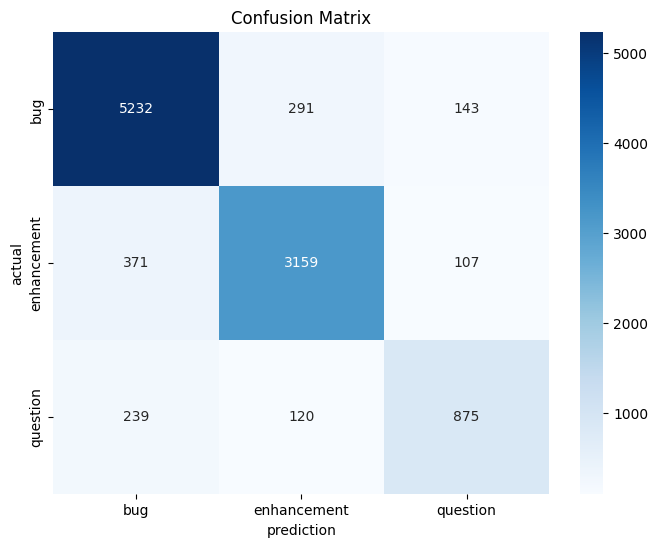

In [19]:
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix,
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            xticklabels = label_names,
            yticklabels = label_names)
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Confusion Matrix')
plt.show()

Performance on nlbse'22 dataset

In [20]:
train_1 = pd.read_csv('data/train_nlbse22_msc_preprocessing_part1.csv')
train_2 = pd.read_csv('data/train_nlbse22_msc_preprocessing_part2.csv')
train_3 = pd.read_csv('data/train_nlbse22_msc_preprocessing_part3.csv')
train_4 = pd.read_csv('data/train_nlbse22_msc_preprocessing_part4.csv')

In [21]:
print(train_1.shape[0], train_2.shape[0], train_3.shape[0], train_4.shape[0])

174170 174170 174170 174169


In [22]:
print(train_1.shape[0] + train_2.shape[0] + train_3.shape[0]+ train_4.shape[0])

696679


In [23]:
test_n = pd.read_csv('data/test_nlbse22_msc_preprocessing.csv')

In [24]:
train_n = pd.concat([train_1, train_2, train_3, train_4], ignore_index = True)
train_n.reset_index(drop = True, inplace = True)

print('Number of issues: ', train_n.shape, test_n.shape)

Number of issues:  (696679, 2) (80518, 2)


In [25]:
nlbse_dataset = pd.concat([train_n, test_n], ignore_index = True)
nlbse_dataset.reset_index(drop = True, inplace = True)
nlbse_dataset.shape[0]

777197

In [26]:
hours, remainder = divmod((datetime.datetime.now() - start).total_seconds(), 3600)
minutes, seconds = divmod(remainder, 60)
print('-'*5,  name, ', duration is:', '%dh:%dm:%ds' % (hours, minutes, seconds), '-'*5, '\n\n')
results_n, model_outputs_n, wrong_pred_n = model.eval_model(nlbse_dataset, verbose=True, **metrics_recom)
results_n

----- roberta , duration is: 0h:28m:2s ----- 




  0%|          | 0/777197 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7772 [00:00<?, ?it/s]

{'mcc': 0.6848538501243984,
 'accuracy': 0.8228904640650955,
 'p_micro': 0.8228904640650955,
 'p_macro': 0.7613588338755356,
 'p_w': 0.8162038484712943,
 'r_micro': 0.8228904640650955,
 'r_macro': 0.7002678923296051,
 'r_w': 0.8228904640650955,
 'f_micro': 0.8228904640650955,
 'f_macro': 0.7198434222640744,
 'f_w': 0.8163384888805764,
 'classificationReport': {'0.0': {'precision': 0.8531505580988632,
   'recall': 0.855028533428187,
   'f1-score': 0.8540885134387076,
   'support': 387966},
  '1.0': {'precision': 0.8121918306655168,
   'recall': 0.8770950066365726,
   'f1-score': 0.8433966137396132,
   'support': 323209},
  '2.0': {'precision': 0.6187341128622268,
   'recall': 0.3686801369240556,
   'f1-score': 0.4620451396139026,
   'support': 66022},
  'accuracy': 0.8228904640650955,
  'macro avg': {'precision': 0.7613588338755356,
   'recall': 0.7002678923296051,
   'f1-score': 0.7198434222640744,
   'support': 777197},
  'weighted avg': {'precision': 0.8162038484712943,
   'recall': 

In [27]:
model_outputs_n.shape[0]

777197

In [28]:
model_outputs_df_n = pd.DataFrame(model_outputs_n, columns = ['bug', 'enhancement', 'question'])
model_outputs_df_n.head()

,bug,enhancement,question
0,0.833008,1.241211,-1.993164
1,0.678711,3.275391,-4.367188
2,0.237915,2.566406,-2.697266
3,1.486328,2.916016,-4.542969
4,-0.797852,4.148438,-3.275391


In [29]:
model_outputs_df_n['prediction'] = model_outputs_df_n.apply(get_prediction, axis = 1)
model_outputs_df_n.head()

,bug,enhancement,question,prediction
0,0.833008,1.241211,-1.993164,1
1,0.678711,3.275391,-4.367188,1
2,0.237915,2.566406,-2.697266,1
3,1.486328,2.916016,-4.542969,1
4,-0.797852,4.148438,-3.275391,1


In [30]:
model_outputs_df_n['actual'] = nlbse_dataset['labels']

In [31]:
predicted_labels_n = model_outputs_df_n['prediction']
actual_labels_n = model_outputs_df_n['actual']

In [32]:
from sklearn.metrics import confusion_matrix

In [33]:
confusion_matrix_n = confusion_matrix(actual_labels_n, predicted_labels_n)
print(confusion_matrix_n)

[[331722  47562   8682]
 [ 33407 283485   6317]
 [ 23691  17990  24341]]


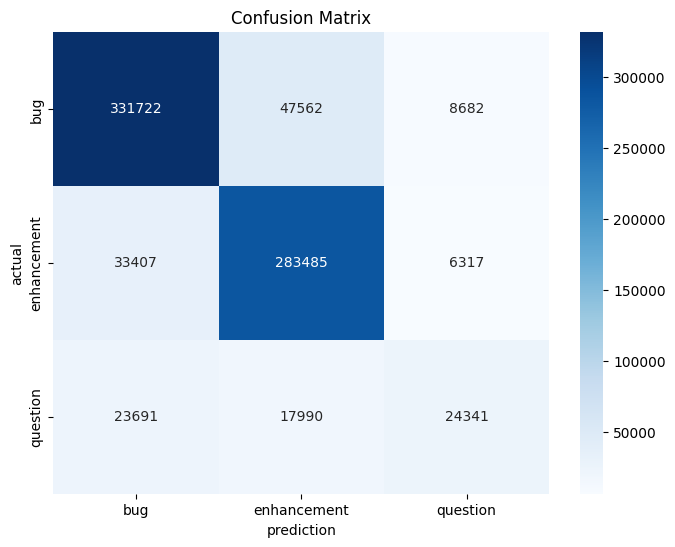

In [34]:
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix_n,
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            xticklabels = label_names,
            yticklabels = label_names)
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Confusion Matrix')
plt.show()

Performance on MSc dataset - bug - enhancement - out-of-scope

In [35]:
train_msc = pd.read_csv('data/train_bug_ench_oos_msc_preprocessing.csv')
test_msc = pd.read_csv('data/test_bug_ench_oos_msc_preprocessing.csv')
print('Number of issues: ', train_msc.shape, test_msc.shape)

Number of issues:  (171392, 2) (19044, 2)


In [36]:
msc_dataset = pd.concat([train_msc, test_msc], ignore_index = True)
msc_dataset.reset_index(drop = True, inplace = True)
msc_dataset.shape[0]

190436

Removing to-be-checked issues

In [37]:
msc_dataset = msc_dataset[msc_dataset['labels'] != 3]
msc_dataset = msc_dataset.reset_index(drop = True)
msc_dataset.shape[0]

171510

In [38]:
msc_dataset['labels'].value_counts()

labels
2    78480
0    56661
1    36369
Name: count, dtype: int64

In [39]:
hours, remainder = divmod((datetime.datetime.now() - start).total_seconds(), 3600)
minutes, seconds = divmod(remainder, 60)
print('-'*5,  name, ', duration is:', '%dh:%dm:%ds' % (hours, minutes, seconds), '-'*5, '\n\n')
results_msc, model_outputs_msc, wrong_pred_msc = model.eval_model(msc_dataset, verbose=True, **metrics_recom)
results_msc

----- roberta , duration is: 0h:55m:12s ----- 




  0%|          | 0/171510 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/1716 [00:00<?, ?it/s]

{'mcc': 0.5033002950414142,
 'accuracy': 0.6050784210833188,
 'p_micro': 0.6050784210833188,
 'p_macro': 0.6836308955039495,
 'p_w': 0.7276734877463528,
 'r_micro': 0.6050784210833188,
 'r_macro': 0.692789899024412,
 'r_w': 0.6050784210833188,
 'f_micro': 0.6050784210833188,
 'f_macro': 0.5840629001250327,
 'f_w': 0.5398243481973989,
 'classificationReport': {'0.0': {'precision': 0.573804859971412,
   'recall': 0.9564427030938388,
   'f1-score': 0.717284555212897,
   'support': 56661},
  '1.0': {'precision': 0.5611581276710755,
   'recall': 0.913415271247491,
   'f1-score': 0.6952117863720073,
   'support': 36369},
  '2.0': {'precision': 0.9159296988693608,
   'recall': 0.2085117227319062,
   'f1-score': 0.33969235879019366,
   'support': 78480},
  'accuracy': 0.6050784210833188,
  'macro avg': {'precision': 0.6836308955039495,
   'recall': 0.692789899024412,
   'f1-score': 0.5840629001250327,
   'support': 171510},
  'weighted avg': {'precision': 0.7276734877463528,
   'recall': 0.605

In [40]:
model_outputs_msc.shape[0]

171510

In [41]:
model_outputs_df_msc = pd.DataFrame(model_outputs_msc, columns = ['bug', 'enhancement', 'out-of-scope'])
model_outputs_df_msc.head()

,bug,enhancement,out-of-scope
0,5.019531,-1.712891,-3.363281
1,4.921875,-2.326172,-2.763672
2,4.957031,-2.292969,-2.873047
3,4.929688,-2.251953,-2.896484
4,4.855469,-2.255859,-2.699219


In [42]:
def get_prediction_oos(row):
  max_value = row.max()
  if max_value == row['bug']:
    return 0
  elif max_value == row['enhancement']:
    return 1
  elif max_value == row['out-of-scope']:
    return 2

In [43]:
label_names = ['bug', 'enhancement', 'out-of-scope']

In [44]:
model_outputs_df_msc['prediction'] = model_outputs_df_msc.apply(get_prediction_oos, axis = 1)
model_outputs_df_msc.head()

,bug,enhancement,out-of-scope,prediction
0,5.019531,-1.712891,-3.363281,0
1,4.921875,-2.326172,-2.763672,0
2,4.957031,-2.292969,-2.873047,0
3,4.929688,-2.251953,-2.896484,0
4,4.855469,-2.255859,-2.699219,0


In [45]:
model_outputs_df_msc['actual'] = msc_dataset['labels']

In [46]:
predicted_labels_msc = model_outputs_df_msc['prediction']
actual_labels_msc = model_outputs_df_msc['actual']

In [47]:
from sklearn.metrics import confusion_matrix

In [49]:
confusion_matrix_msc = confusion_matrix(actual_labels_msc, predicted_labels_msc)
print(confusion_matrix_msc)

[[54193  1673   795]
 [ 2442 33220   707]
 [37810 24306 16364]]


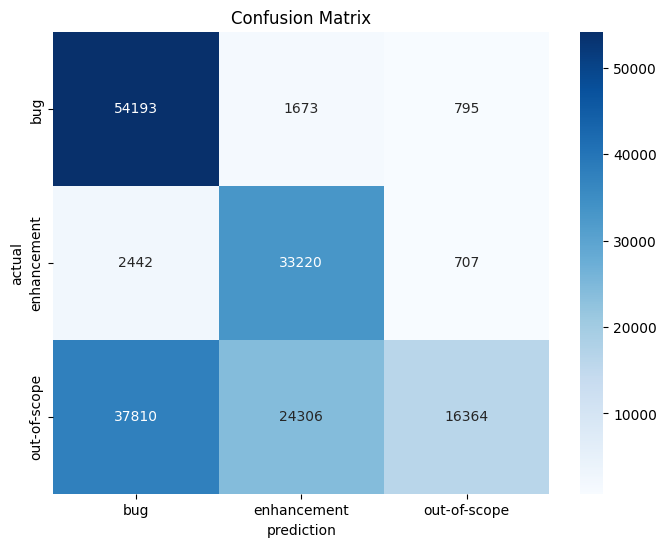

In [50]:
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix_msc,
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            xticklabels = label_names,
            yticklabels = label_names)
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Confusion Matrix')
plt.show()